In [33]:
%load_ext autoreload
%autoreload 2
import os, sys, json
import itertools
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import requests
from fractions import Fraction
print(os.getcwd())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/vladislav_veselov/work and study/OmutAI/CU_ResearchAI/week_9


Создадим датасет, где хотя бы одно из слагаемых является несократимой дробью. Возьмем значения побольше, чтобы модель не выбивала 1.0

In [2]:
class Dataset:
    def __init__(self):
        self.hard_denum = [11, 13, 17, 31, 37, 41]
        self.hard_num = [5, 10, 16, 24, 34, 42]
        self.hard_drobs = [i for i in itertools.product(self.hard_num, self.hard_denum)]
        self.drobs = [i for i in itertools.product(list(range(10, 17)), list(range(11, 18)))][:-8]
        self.drobs = [i for i in self.drobs if i[0] != i[1]]
        
    def __getitem__(self, x):
        fst = f"{self.drobs[x][0]}/{self.drobs[x][1]} + "
        sec = f"{self.hard_drobs[x][0]}/{self.hard_drobs[x][1]}"
        return fst + sec

    def __len__(self):
        assert len(self.hard_drobs) == len(self.drobs)
        return len(self.drobs)
    
data = Dataset()

Преобразуем ответы в дроби, которые мы ожидаем увидеть от модели

In [69]:
answers = [str(Fraction(eval(i)).limit_denominator()) for i in data]

In [4]:
os.environ['apikey'] = '<YOUR API KEY>'

url = "https://www.neuronpedia.org/api/steer-chat"
headers = { "Content-Type": "application/json",
            "x-api-key": os.getenv('apikey')
}
model_id = "deepseek-r1-distill-llama-8b"
features = {
    "modelId": "deepseek-r1-distill-llama-8b",
    "layer": "15-llamascope-slimpj-res-32k",
    "index": 30939
}


Скрипт для валидации ответов

In [5]:
def evaluate(
        query: str,
        strength: float, 
        strength_multiplier: float = 1.0,
        temperature: float = 0.0,
        freq_penalty: float = 1.0,
        repetition_penalty: float = 1.0,
        n_tokens: int = 768,
        seed: int = 16,
) -> dict:
    features.update({"strength": strength})
    resp = requests.post(
        url,
      headers=headers,
      json={
        "defaultChatMessages": [
          {
            "role": "user",
            "content": query
          }
        ],
        "steeredChatMessages": [
          {
            "role": "user",
            "content": query
          }
        ],
        "modelId": model_id,
        "features": [
            features
        ],
        "temperature": temperature,
        "n_tokens": n_tokens,
        "freq_penalty": freq_penalty,
        "repetition_penalty": repetition_penalty,
        "seed": seed,
        "strength_multiplier": strength_multiplier,
        "steer_special_tokens": True
      }
    )
    return resp.json()

In [6]:
import time

Будем менять силу стиринга от -2 до 5.5 с шагом 0.5. Можно и больше, но апи душат по числу запросов, из-за чего время генерации кратно увеличивается. 

In [51]:
first_step = True
answers_dict = defaultdict(list)
default_answers = None
for strength in tqdm(np.arange(1, 6, 0.5), desc=f'steering in progress...', total=10):
    while True:
        try:
            answers_steered = []
            answers = []
            for query in tqdm(data):
                print(query)
                resp = evaluate(f"what is {query}?", strength)
                print('Done!')
                if first_step:
                    answers.append(resp['DEFAULT']['chatTemplate'][1]['content'])
                answers_steered.append(resp['STEERED']['chatTemplate'][1]['content'])
            if first_step: 
                default_answers = answers
                first_step = False
            answers_dict[strength].append(answers_steered)
            break
        except:
            time.sleep(600)
        

steering in progress...:   0%|          | 0/10 [00:00<?, ?it/s]

10/11 + 5/11


  3%|▎         | 1/36 [00:00<00:34,  1.03it/s]

Done!
10/12 + 5/13



steering in progress...:   0%|          | 0/10 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [49]:
x2 = [-3, -2, -1.5, -1, -0.5, 0.5]

In [55]:
for strength in tqdm(x2, desc=f'steering in progress...', total=6): 
    while True:
        try:
            answers_steered = []
            for query in tqdm(data):
                print(query)
                resp = evaluate(f"what is {query}?", strength)
                print('Done!')
                answers_steered.append(resp['STEERED']['chatTemplate'][1]['content'])
            answers_dict[strength].append(answers_steered)
            break
        except:
            time.sleep(600)
        

steering in progress...:   0%|          | 0/6 [00:00<?, ?it/s]


  0%|          | 0/36 [00:00<?, ?it/s]

10/11 + 5/11


Done!
10/12 + 5/13


Done!
10/13 + 5/17


Done!
10/14 + 5/31


Done!
10/15 + 5/37


Done!
10/16 + 5/41


Done!
10/17 + 10/11


Done!
11/12 + 10/13


Done!
11/13 + 10/17


Done!
11/14 + 10/31


Done!
11/15 + 10/37


Done!
11/16 + 10/41


Done!
11/17 + 16/11


Done!
12/11 + 16/13


Done!
12/13 + 16/17


Done!
12/14 + 16/31


Done!
12/15 + 16/37


Done!
12/16 + 16/41


Done!
12/17 + 24/11


Done!
13/11 + 24/13


Done!
13/12 + 24/17


Done!
13/14 + 24/31


Done!
13/15 + 24/37


Done!
13/16 + 24/41


Done!
13/17 + 34/11


Done!
14/11 + 34/13


Done!
14/12 + 34/17


Done!
14/13 + 34/31


Done!
14/15 + 34/37


Done!
14/16 + 34/41


Done!
14/17 + 42/11


Done!
15/11 + 42/13


Done!
15/12 + 42/17


Done!
15/13 + 42/31


Done!
15/14 + 42/37


Done!
15/16 + 42/41


steering in progress...:  17%|█▋        | 1/6 [00:27<02:18, 27.71s/it]

Done!


10/11 + 5/11


Done!
10/12 + 5/13


Done!
10/13 + 5/17


Done!
10/14 + 5/31


Done!
10/15 + 5/37


Done!
10/16 + 5/41


Done!
10/17 + 10/11


Done!
11/12 + 10/13


Done!
11/13 + 10/17


Done!
11/14 + 10/31


Done!
11/15 + 10/37


Done!
11/16 + 10/41


Done!
11/17 + 16/11


Done!
12/11 + 16/13


Done!
12/13 + 16/17


Done!
12/14 + 16/31


Done!
12/15 + 16/37


Done!
12/16 + 16/41


Done!
12/17 + 24/11


Done!
13/11 + 24/13


Done!
13/12 + 24/17


Done!
13/14 + 24/31


Done!
13/15 + 24/37


Done!
13/16 + 24/41


Done!
13/17 + 34/11


Done!
14/11 + 34/13


Done!
14/12 + 34/17


Done!
14/13 + 34/31


Done!
14/15 + 34/37


Done!
14/16 + 34/41


Done!
14/17 + 42/11


Done!
15/11 + 42/13


Done!
15/12 + 42/17


Done!
15/13 + 42/31


Done!
15/14 + 42/37


Done!
15/16 + 42/41


steering in progress...:  33%|███▎      | 2/6 [00:52<01:43, 25.88s/it]

Done!


10/11 + 5/11


Done!
10/12 + 5/13


Done!
10/13 + 5/17


Done!
10/14 + 5/31


Done!
10/15 + 5/37


Done!
10/16 + 5/41


Done!
10/17 + 10/11


Done!
11/12 + 10/13


Done!
11/13 + 10/17


Done!
11/14 + 10/31


Done!
11/15 + 10/37


Done!
11/16 + 10/41


Done!
11/17 + 16/11


Done!
12/11 + 16/13


Done!
12/13 + 16/17


Done!
12/14 + 16/31


Done!
12/15 + 16/37


Done!
12/16 + 16/41


Done!
12/17 + 24/11


Done!
13/11 + 24/13


Done!
13/12 + 24/17


Done!
13/14 + 24/31


Done!
13/15 + 24/37


Done!
13/16 + 24/41


Done!
13/17 + 34/11


Done!
14/11 + 34/13


Done!
14/12 + 34/17


Done!
14/13 + 34/31


Done!
14/15 + 34/37


Done!
14/16 + 34/41


Done!
14/17 + 42/11


Done!
15/11 + 42/13


Done!
15/12 + 42/17


Done!
15/13 + 42/31


Done!
15/14 + 42/37


Done!
15/16 + 42/41


steering in progress...:  50%|█████     | 3/6 [01:15<01:14, 24.82s/it]

Done!


10/11 + 5/11


Done!
10/12 + 5/13


Done!
10/13 + 5/17


Done!
10/14 + 5/31


Done!
10/15 + 5/37


Done!
10/16 + 5/41


Done!
10/17 + 10/11


Done!
11/12 + 10/13


Done!
11/13 + 10/17


Done!
11/14 + 10/31


Done!
11/15 + 10/37


Done!
11/16 + 10/41


Done!
11/17 + 16/11


Done!
12/11 + 16/13


Done!
12/13 + 16/17


Done!
12/14 + 16/31


Done!
12/15 + 16/37


Done!
12/16 + 16/41


Done!
12/17 + 24/11


Done!
13/11 + 24/13


Done!
13/12 + 24/17


Done!
13/14 + 24/31


Done!
13/15 + 24/37


Done!
13/16 + 24/41


Done!
13/17 + 34/11


Done!
14/11 + 34/13


Done!
14/12 + 34/17


Done!
14/13 + 34/31


Done!
14/15 + 34/37


Done!
14/16 + 34/41


Done!
14/17 + 42/11


Done!
15/11 + 42/13


Done!
15/12 + 42/17


Done!
15/13 + 42/31


Done!
15/14 + 42/37


Done!
15/16 + 42/41


steering in progress...:  67%|██████▋   | 4/6 [01:40<00:49, 24.69s/it]

Done!


10/11 + 5/11


Done!
10/12 + 5/13


Done!
10/13 + 5/17


Done!
10/14 + 5/31


Done!
10/15 + 5/37


Done!
10/16 + 5/41


Done!
10/17 + 10/11


Done!
11/12 + 10/13


Done!
11/13 + 10/17


Done!
11/14 + 10/31


Done!
11/15 + 10/37


Done!
11/16 + 10/41


Done!
11/17 + 16/11


Done!
12/11 + 16/13


Done!
12/13 + 16/17


Done!
12/14 + 16/31


Done!
12/15 + 16/37


Done!
12/16 + 16/41


Done!
12/17 + 24/11


Done!
13/11 + 24/13


Done!
13/12 + 24/17


Done!
13/14 + 24/31


Done!
13/15 + 24/37


Done!
13/16 + 24/41


Done!
13/17 + 34/11


Done!
14/11 + 34/13


Done!
14/12 + 34/17


Done!
14/13 + 34/31


Done!
14/15 + 34/37


Done!
14/16 + 34/41


Done!
14/17 + 42/11


Done!
15/11 + 42/13


Done!
15/12 + 42/17


Done!
15/13 + 42/31


Done!
15/14 + 42/37


Done!
15/16 + 42/41


steering in progress...:  83%|████████▎ | 5/6 [37:46<13:16, 796.93s/it]

Done!


10/11 + 5/11


Done!
10/12 + 5/13


Done!
10/13 + 5/17


Done!
10/14 + 5/31


Done!
10/15 + 5/37


Done!
10/16 + 5/41


Done!
10/17 + 10/11


Done!
11/12 + 10/13


Done!
11/13 + 10/17


Done!
11/14 + 10/31


Done!
11/15 + 10/37


Done!
11/16 + 10/41


Done!
11/17 + 16/11


Done!
12/11 + 16/13


Done!
12/13 + 16/17


Done!
12/14 + 16/31


Done!
12/15 + 16/37


Done!
12/16 + 16/41


Done!
12/17 + 24/11


Done!
13/11 + 24/13


Done!
13/12 + 24/17


Done!
13/14 + 24/31


Done!
13/15 + 24/37


Done!
13/16 + 24/41


Done!
13/17 + 34/11


Done!
14/11 + 34/13


Done!
14/12 + 34/17


Done!
14/13 + 34/31


Done!
14/15 + 34/37


Done!
14/16 + 34/41


Done!
14/17 + 42/11


Done!
15/11 + 42/13


Done!
15/12 + 42/17


Done!
15/13 + 42/31


Done!
15/14 + 42/37


Done!
15/16 + 42/41


steering in progress...: 100%|██████████| 6/6 [54:55<00:00, 549.17s/it]

Done!


In [56]:
import pandas as pd
# pd.to_pickle(answers_dict, 'answer_dict_neg.pkl')
# pd.to_pickle(answers_dict, 'answer_dict.pkl')
# pd.to_pickle(default_answers, 'default_answers.pkl')

In [62]:
answers_dict = pd.read_pickle('answer_dict_neg.pkl')
answers_dict.update(pd.read_pickle('answer_dict.pkl'))
default_answers = pd.read_pickle('default_answers.pkl')

In [71]:
def parse_answer(ans):
    num, denum = ans.split('/')
    return r'frac'+'{'+num+'}'+'{'+denum+'}'

In [72]:
defaults_scores = np.zeros(len(data))
for i, (text, ans) in enumerate(zip(default_answers, answers)):
    defaults_scores[i] = int(parse_answer(ans) in text)

In [73]:
scores = np.zeros((16, len(data)))
for j, strength in enumerate(answers_dict):
    for i, (text, ans) in enumerate(zip(answers_dict[strength][0], answers)):
        scores[j][i] = int(parse_answer(ans) in text)

In [74]:
default_score_mean = defaults_scores.sum() / defaults_scores.shape[-1] 

In [75]:
mean_scores = scores.sum(axis=1) / scores.shape[-1] 

In [76]:
x = np.arange(-2, 6, 0.5)

Как можем заметить ниже, стиринг действительно может повлиять на результат модели, благодаря чему повышается качество.
Лучшие ответы были получены при значении стиринга, равного 4.5

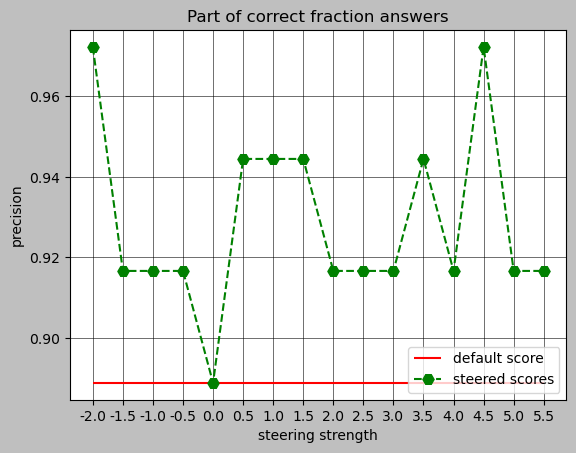

In [82]:
with plt.style.context('grayscale'):
    plt.grid(linewidth=0.4)
    plt.hlines(xmin=0, xmax=15, y=default_score_mean, colors='r', label='default score')
    plt.plot(list(range(16)), mean_scores, 'g--H', markersize=8, label='steered scores')
    plt.title('Part of correct fraction answers')
    plt.xlabel('steering strength')
    plt.ylabel('precision')
    plt.legend()
    plt.xticks(ticks=list(range(16)),labels=x)
    plt.savefig('steering_scores.png')
    plt.show()